In [1]:
from netCDF4 import Dataset, date2num, num2date
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
%matplotlib inline

In [36]:
import glob
readDir = '/srv/data2/srai_poseidon/srai_poseidon/observation/SatelliteVsBuoy/downloads/TRMM_data/downloaded/'
fileList = glob.glob(readDir + '*/dateFixed*.nc')

In [38]:
len(fileList)

39670

In [14]:
ds

<xarray.Dataset>
Dimensions:       (time: 9140, nray: 49, fakeDim8: 2, ncell1: 80)
Coordinates:
  * time          (time) datetime64[ns] 2000-02-09T09:13:13.000443 ... 2000-0...
Dimensions without coordinates: nray, fakeDim8, ncell1
Data variables:
    nearSurfRain  (time, nray) float32 ...
    e_SurfRain    (time, nray) float32 ...
    rainAve       (time, nray, fakeDim8) float32 ...
    rainFlag      (time, nray) int16 ...
    rainType      (time, nray) int16 ...
    rain          (time, nray, ncell1) int16 ...
    Latitude      (time, nray) float32 -36.12 -36.08 -36.03 ... -34.2 -34.16
    Longitude     (time, nray) float32 343.9 343.9 343.9 ... 320.6 320.6 320.6

In [13]:
ds= xr.open_dataset('/srv/data2/srai_poseidon/srai_poseidon/observation/SatelliteVsBuoy/downloads/TRMM_data/downloaded/TRMM_nc_2000/dateFixed_2A25.20000209.12671.7.nc')

tol = 0.1
count = 0
rank = 0

thisLat = 0
thisLon = -140

ds = ds.rename({'Time':'time'})

ds['Longitude'] = (ds['Longitude'] + 360)%360

if thisLat < 0:
    latUnit = 'S'
else:
    latUnit = 'N'

if thisLon < 0:
    lonUnit = 'W'
else:
    lonUnit = 'E'

wFile = f'T_{abs(thisLat):03.0f}{latUnit:s}_{abs(thisLon):03.0f}{lonUnit:s}_TRMM_fileNumber{count:06d}_rank{rank:02d}.nc'
thisLon = (thisLon + 360)%360

mask = np.logical_and((abs(ds['Latitude'] - thisLat) < tol), (abs(ds['Longitude'] - thisLon) < tol))
if np.sum(mask) > 0:
    sub_ds = ds.where(mask, drop=True)
    tlen = len(sub_ds['time'])
    wds = xr.Dataset()
    
    #### ALL THIS LENGTHY PROCESS JUST TO MAKE THE ARRAY SIZE IS SAME EXCEPT FOR THE APPENDING DIMENSION
    for var in list(sub_ds.keys()):
        if var not in ['rainAve', 'rain']:
            newArr = np.zeros((tlen, 3)) * np.nan
            for t in range(tlen):
                for i in range(min(len(sub_ds[var][t,:]), 3)):
                    newArr[t,i] = sub_ds[var][t,i]
            wds[var] = xr.DataArray(newArr, 
                                    dims = ['time', 'nray'],
                                    coords = {'time':sub_ds['time'],
                                              'nray':np.arange(3)},
                                    attrs = sub_ds[var].attrs)
        elif var == 'rainAve':
            newArr = np.zeros((tlen, 3, 2)) * np.nan
            for t in range(tlen):
                for i in range(min(len(sub_ds[var][t,:]), 3)):
                    newArr[t,i] = sub_ds[var][t,i]
            wds[var] = xr.DataArray(newArr, 
                                    dims = ['time', 'nray', 'fakeDim8'],
                                    coords = {'time':sub_ds['time'],
                                              'nray':np.arange(3),
                                              'fakeDim8':np.arange(2)},
                                    attrs = sub_ds[var].attrs)
            
        elif var == 'rain':
            newArr = np.zeros((tlen, 3, 80)) * np.nan
            for t in range(tlen):
                for i in range(len(sub_ds[var][t,:])):
                    newArr[t,i,:] = sub_ds[var][t,i,:]
            wds[var] = xr.DataArray(newArr, 
                                    dims = ['time', 'nray', 'ncell1'],
                                    coords = {'time':sub_ds['time'],
                                              'nray':np.arange(3),
                                              'ncell1':np.arange(2)},
                                    attrs = sub_ds[var].attrs)

In [8]:
dates = num2date(np.array(ds.variables['Time']), ds.variables['Time'].units)


In [13]:
dates

array([cftime.DatetimeGregorian(2000, 8, 11, 19, 1, 38, 177, has_year_zero=False),
       cftime.DatetimeGregorian(2000, 8, 11, 19, 1, 38, 776, has_year_zero=False),
       cftime.DatetimeGregorian(2000, 8, 11, 19, 1, 39, 376, has_year_zero=False),
       ...,
       cftime.DatetimeGregorian(2000, 8, 11, 20, 32, 54, 670, has_year_zero=False),
       cftime.DatetimeGregorian(2000, 8, 11, 20, 32, 55, 270, has_year_zero=False),
       cftime.DatetimeGregorian(2000, 8, 11, 20, 32, 55, 869, has_year_zero=False)],
      dtype=object)

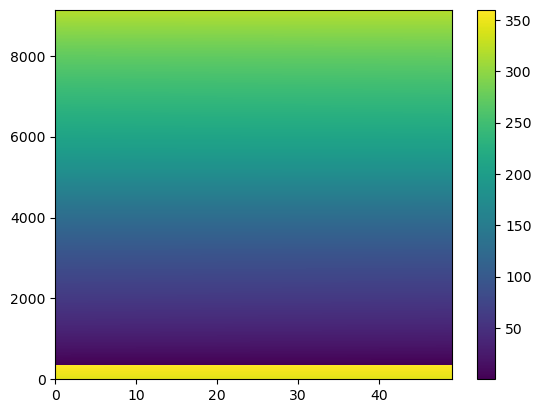

In [16]:
plt.pcolormesh(ds['Longitude'])
plt.colorbar()

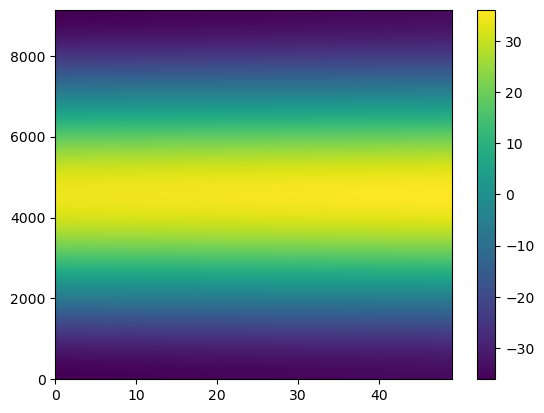

In [17]:
plt.pcolormesh(ds['Latitude'])
plt.colorbar()

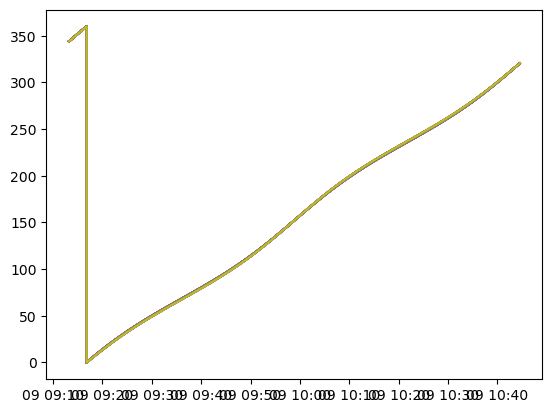

In [18]:
plt.plot(ds['time'], ds['Longitude'])

/tmp/ipykernel_539122/3516081027.py:1: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(ds['Longitude'], ds['Latitude'], ds['nearSurfRain'])


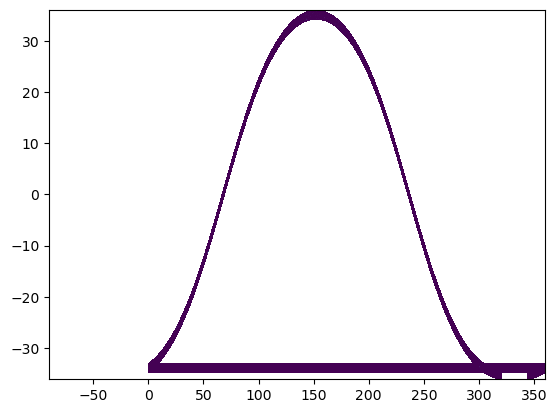

In [22]:
plt.pcolormesh(ds['Longitude'], ds['Latitude'], ds['nearSurfRain'])

/tmp/ipykernel_539122/2313949082.py:1: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(ds['Longitude'], ds['Latitude'], mask)


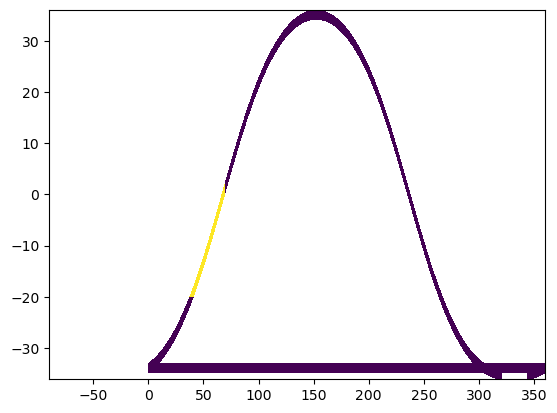

In [35]:
plt.pcolormesh(ds['Longitude'], ds['Latitude'], mask)
#plt.colorbar()

In [33]:
thisLat = 0
thisLon = 50
tol = 20
mask = np.logical_and((abs(ds['Latitude'] - thisLat) < tol), (abs(ds['Longitude'] - thisLon) < tol))

In [34]:
np.sum(mask.to_numpy())

48500